In [3]:
import os
import joblib
from glob import glob
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

import torch.nn as nn
import torch.optim as optim

from sentimentRNN import datasetclass
from sentimentRNN import textpreprocess

# create vocab

In [4]:
tokenizer = get_tokenizer("basic_english")

fns = glob(os.path.join('train', '*', '*.txt'))

def yield_tokens(fns):
    for fn in fns:
        with open(fn, 'r') as f:
            text = f.readlines()[0]
            tokens = tokenizer(textpreprocess.clean_text(text))
            yield tokens

# make vocabulary from tokenized text
vocab = build_vocab_from_iterator(yield_tokens(fns))

25000lines [00:05, 4759.21lines/s]


# Create Dataset

In [41]:
# train
import random

fns = glob(os.path.join('train', '*', '*.txt'))
# fns = random.sample(fns, 12_000)
label_map = {'pos': 1, 'neg': 0}

dataset = datasetclass.TextSentimentDataset(fns, tokenizer, vocab, label_map)
def collate_batch(batch):
    text_list, label_list = [], []
    for _text, _label in batch:
        text_list.append(torch.tensor(_text))
        label_list.append(torch.tensor(_label))
    
    # pad sequences so that each one has the same length (for training)
    text_list = pad_sequence(text_list, batch_first=True, padding_value=0)
    
    return text_list, torch.tensor(label_list)

print(len(dataset))
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)
print(len(train_dataloader))


25000
782


In [42]:
# test
fns = glob(os.path.join('test', '*', '*.txt'))
fns = random.sample(fns, 12000)

label_map = {'pos': 1, 'neg': 0}

dataset = datasetclass.TextSentimentDataset(fns, tokenizer, vocab, label_map)
def collate_batch(batch):
    text_list, label_list = [], []
    for _text, _label in batch:
        text_list.append(torch.tensor(_text))
        label_list.append(torch.tensor(_label))
    
    # pad sequences so that each one has the same length (for training)
    text_list = pad_sequence(text_list, batch_first=True, padding_value=0)
    
    return text_list, torch.tensor(label_list)

print(len(dataset))
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)
print(len(test_dataloader))


12000
375


# Train Model

In [43]:

def evaluate(model, dataloader, criterion, device):
    model.eval()  # when used during training loop super important this
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # no need to compute gradients during evaluation
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            
            outputs = model(texts)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # predicted labels
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = test_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


# Model

In [44]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size) # create embedding for sequence
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size) # classification head

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        out = self.fc(hidden[-1])
        return out

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)  # embedd input sequence
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)  
        self.fc = nn.Linear(hidden_size, output_size)  # classification head

    def forward(self, x):
        embedded = self.embedding(x)  
        output, (hidden, cell) = self.lstm(embedded)  
        out = self.fc(hidden[-1])  
        return out


Running on cuda


  0%|          | 0/782 [00:00<?, ?it/s]C:\Users\jnicolow\AppData\Local\Temp\ipykernel_1104\2909939629.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_list.append(torch.tensor(_text))
C:\Users\jnicolow\AppData\Local\Temp\ipykernel_1104\2909939629.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_list.append(torch.tensor(_label))
100%|██████████| 782/782 [00:25<00:00, 31.15it/s]
C:\Users\jnicolow\AppData\Local\Temp\ipykernel_1104\1323889746.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_list.append(torch.tensor

Epoch 1/15, Train Loss: 0.9109, Test Loss: 0.8836, Test Accuracy: 52.47%


100%|██████████| 782/782 [00:25<00:00, 30.70it/s]


Epoch 2/15, Train Loss: 0.9085, Test Loss: 0.8200, Test Accuracy: 51.93%


100%|██████████| 782/782 [00:25<00:00, 31.09it/s]


Epoch 3/15, Train Loss: 0.9157, Test Loss: 0.9290, Test Accuracy: 50.72%


100%|██████████| 782/782 [00:25<00:00, 30.87it/s]


Epoch 4/15, Train Loss: 0.9479, Test Loss: 1.1759, Test Accuracy: 50.13%


100%|██████████| 782/782 [00:25<00:00, 30.59it/s]


Epoch 5/15, Train Loss: 0.9148, Test Loss: 0.8810, Test Accuracy: 50.41%


100%|██████████| 782/782 [00:25<00:00, 30.60it/s]


Epoch 6/15, Train Loss: 0.8962, Test Loss: 0.8281, Test Accuracy: 51.46%


100%|██████████| 782/782 [00:25<00:00, 30.85it/s]


Epoch 7/15, Train Loss: 0.9168, Test Loss: 0.8716, Test Accuracy: 52.89%


100%|██████████| 782/782 [00:25<00:00, 30.55it/s]


Epoch 8/15, Train Loss: 0.9115, Test Loss: 1.1863, Test Accuracy: 50.07%


100%|██████████| 782/782 [00:25<00:00, 30.55it/s]


Epoch 9/15, Train Loss: 0.9446, Test Loss: 0.8099, Test Accuracy: 52.51%


100%|██████████| 782/782 [00:25<00:00, 30.65it/s]


Epoch 10/15, Train Loss: 0.9073, Test Loss: 1.0864, Test Accuracy: 50.74%


100%|██████████| 782/782 [00:25<00:00, 30.59it/s]


Epoch 11/15, Train Loss: 0.8966, Test Loss: 0.9142, Test Accuracy: 50.41%


100%|██████████| 782/782 [00:24<00:00, 31.59it/s]


Epoch 12/15, Train Loss: 0.9051, Test Loss: 0.8316, Test Accuracy: 51.76%


100%|██████████| 782/782 [00:25<00:00, 30.28it/s]


Epoch 13/15, Train Loss: 0.9021, Test Loss: 0.8307, Test Accuracy: 51.58%


100%|██████████| 782/782 [00:25<00:00, 30.96it/s]


Epoch 14/15, Train Loss: nan, Test Loss: nan, Test Accuracy: 49.84%


100%|██████████| 782/782 [00:25<00:00, 30.26it/s]


Epoch 15/15, Train Loss: nan, Test Loss: nan, Test Accuracy: 49.84%


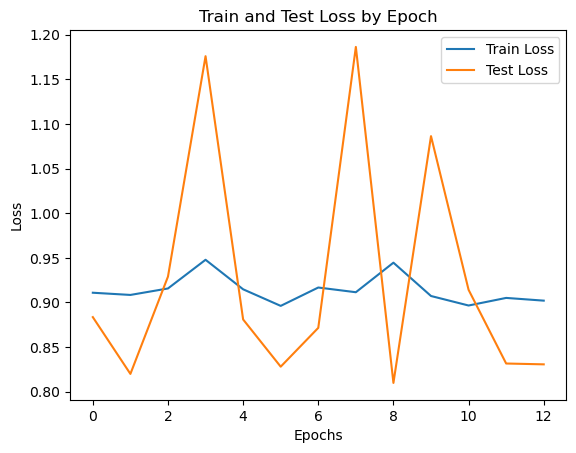

In [45]:
import matplotlib.pyplot as plt
# hyperparameters
vocab_size = len(vocab)
embed_size = 300 # 300 is a common size in previous models
hidden_size = 256 # 512
output_size = 2  # pos or neg
learning_rate = 0.07
num_epochs = 15

# set device
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'
print(f'Running on {device}')

# initialize model, loss, and optimizer
model = LSTMModel(vocab_size, embed_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_losses = []
test_losses = []
# train loop
for epoch in range(num_epochs):
    model.train() # in evaluation its set to eval mode so needs to be put back
    running_loss = 0.0
    for texts, labels in tqdm(train_dataloader):
        texts, labels = texts.to(device), labels.to(device) # move to the correct device
        outputs = model(texts)
        loss = criterion(outputs, labels)

        running_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # test eval
    test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)
    test_losses.append(test_loss) 


    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, 'f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

train_losses = [float(train_loss.detach().cpu()) for train_loss in train_losses] 
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss by Epoch')
plt.legend()
plt.show()


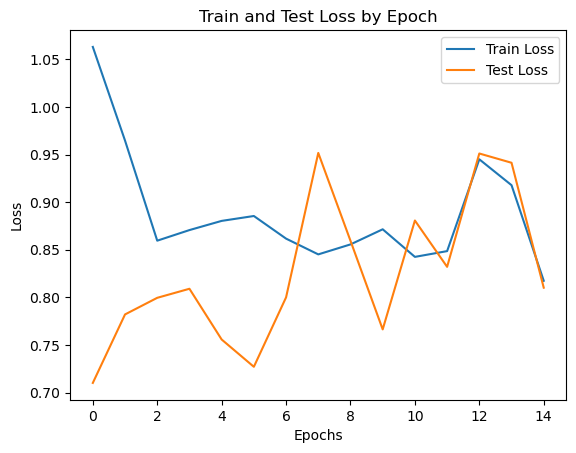

In [39]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss by Epoch')
plt.legend()
plt.show()

In [37]:
train_losses

[1.0631256103515625,
 0.9647095203399658,
 0.8595414757728577,
 0.8706802725791931,
 0.8803297281265259,
 0.885468065738678,
 0.8616911768913269,
 0.8451360464096069,
 0.8556233048439026,
 0.871504545211792,
 0.842513918876648,
 0.8485729694366455,
 0.9450353384017944,
 0.9178504943847656,
 0.817412257194519]

In [18]:
joblib.dump(model, '500 epoch.pkl')

['first model atempt.pkl']

In [1]:

import torch
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)

PyTorch Version: 2.4.1
CUDA Available: True
CUDA Version: 12.4
